In [ ]:
import yaml
import umap

import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from carot.datasets.single_loader import CarModule
from carot.utils import score_transports_and_targets_combinations
from cmonge.utils import load_config
from cmonge.anaylsis import monge_get_source_target_transport
from cmonge.trainers.ot_trainer import MongeMapTrainer

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'carot'

In [2]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "monge": default_colors["cyan"],
    "cmonge": default_colors["indigo"],
    "within condition": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}


In [3]:
features = "/path/to/genesets/functional_and_score_genes.txt"

logger_path = "/path/to/dummy/logger/notebook_logger.json"
base_config_path = "/path/to/model/configs/monge/"
base_ckpt_path = "/path/to/model/checkpoints/monge/"
base_fig_save = "/path/to/figures/transport_UMAPs/monge/"

In [4]:
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f'/path/to/data/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1

    with plt.rc_context():
    
        sc.pl.umap(sel_adata, color=["CAR_Variant", "ident", "Time", "Donor"], frameon=False, ncols=1,
                  show=False, linewidth=0)
        plt.savefig(f"/path/to/figures/transport_UMAPs/{subset}_UMAP.pdf", bbox_inches = "tight", dpi=300)
        plt.savefig(f"/path/to/figures/transport_UMAPs/{subset}_UMAP.png", bbox_inches = "tight", dpi=300)
        plt.close()

    for car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        config_path = f"{base_config_path}FuncScore/{subset}/NA-NA-NA_{car}_config.yaml"
        config = load_config(config_path)
        config.model.checkpointing_path = f"{base_ckpt_path}NoEmbed_FuncScore_Monge_{subset}NA-NA-NA_{car}/"
        config.data.file_path = f"/path/to/data/{subset}.h5ad"
        config.data.features = features
        config.data.drugs_path = "/path/to/variants/CAR_variants.txt"

        datamodule = CarModule(config.data)
        trainer = MongeMapTrainer.load_checkpoint(
                jobid=1, config=config.model, logger_path=logger_path
            )

        size = min(len(datamodule.control_valid_cells), len(datamodule.target_valid_cells))
        all_expr, all_meta = monge_get_source_target_transport(datamodule=datamodule, trainer=trainer, batch_size=size)

        Y2 = umapper.transform(all_expr)

        all_meta[["UMAP1", "UMAP2"]] = Y2

        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color="grey", s=5, alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=20, palette=ot_map, alpha=0.95, linewidth=0.15)
        plt.legend([],[], frameon=False)
        plt.tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)

        plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.pdf", bbox_inches="tight", dpi=300)
        plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.png", bbox_inches="tight", dpi=300)
        plt.close()

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_51148/1211529222.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterpl

41BB-41BB-z


2024-09-19 15:09:00.125 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:09:00.610 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2024-09-19 15:09:00.610 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:09:00.611 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:09:00.612 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:09:01.611 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
41BB-CD28-z


2024-09-19 15:09:18.051 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:09:18.071 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2024-09-19 15:09:18.072 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:09:18.072 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:09:18.074 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:09:18.271 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
41BB-CD40-z


2024-09-19 15:09:22.244 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:09:22.263 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2024-09-19 15:09:22.264 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:09:22.264 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:09:22.266 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:09:22.302 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
41BB-CTLA4-z


2024-09-19 15:09:26.836 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:09:26.854 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2024-09-19 15:09:26.854 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:09:26.855 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:09:26.856 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:09:26.890 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
41BB-IL15RA-z


2024-09-19 15:09:32.321 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:09:32.346 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2024-09-19 15:09:32.347 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:09:32.348 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:09:32.349 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:09:32.578 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
41BB-NA-z


2024-09-19 15:09:37.093 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:09:37.111 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2024-09-19 15:09:37.112 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:09:37.113 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:09:37.113 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:09:37.144 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-41BB-z


2024-09-19 15:09:42.700 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:09:42.722 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2024-09-19 15:09:42.723 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:09:42.724 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:09:42.725 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:09:42.756 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-CD28-z


2024-09-19 15:09:47.394 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:09:47.414 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2024-09-19 15:09:47.415 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:09:47.416 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:09:47.417 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:09:47.447 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-CD40-z


2024-09-19 15:09:51.565 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:09:51.583 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2024-09-19 15:09:51.584 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:09:51.585 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:09:51.585 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:09:51.615 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-CTLA4-z


2024-09-19 15:09:55.663 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:09:55.681 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2024-09-19 15:09:55.682 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:09:55.683 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:09:55.684 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:09:55.719 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-IL15RA-z


2024-09-19 15:10:00.427 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:00.448 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2024-09-19 15:10:00.450 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:00.450 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:00.451 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:00.494 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-NA-z


2024-09-19 15:10:05.058 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:05.077 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2024-09-19 15:10:05.078 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:05.078 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:05.079 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:05.107 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-41BB-z


2024-09-19 15:10:09.594 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:09.613 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2024-09-19 15:10:09.614 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:09.615 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:09.616 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:09.647 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-CD28-z


2024-09-19 15:10:14.189 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:14.208 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2024-09-19 15:10:14.209 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:14.210 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:14.211 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:14.271 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-CD40-z


2024-09-19 15:10:18.830 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:18.849 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2024-09-19 15:10:18.850 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:18.850 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:18.851 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:18.884 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-CTLA4-z


2024-09-19 15:10:23.631 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:23.649 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2024-09-19 15:10:23.650 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:23.650 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:23.651 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:23.680 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-IL15RA-z


2024-09-19 15:10:28.242 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:28.265 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2024-09-19 15:10:28.266 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:28.267 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:28.268 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:28.307 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-NA-z


2024-09-19 15:10:33.956 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:33.977 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2024-09-19 15:10:33.978 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:33.978 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:33.979 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:34.009 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-41BB-z


2024-09-19 15:10:39.134 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:39.151 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2024-09-19 15:10:39.152 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:39.152 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:39.153 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:39.188 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-CD28-z


2024-09-19 15:10:44.513 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:44.532 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2024-09-19 15:10:44.532 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:44.533 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:44.534 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:44.564 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-CD40-z


2024-09-19 15:10:49.752 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:49.777 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2024-09-19 15:10:49.777 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:49.778 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:49.779 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:49.820 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-CTLA4-z


2024-09-19 15:10:54.273 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:54.290 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2024-09-19 15:10:54.290 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:54.291 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:54.292 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:54.474 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-IL15RA-z


2024-09-19 15:10:58.737 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:10:58.757 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2024-09-19 15:10:58.757 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:10:58.758 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:10:58.759 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:10:58.938 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-NA-z


2024-09-19 15:11:04.588 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:11:04.763 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2024-09-19 15:11:04.764 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:11:04.766 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:11:04.767 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:11:04.804 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-41BB-z


2024-09-19 15:11:09.064 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:11:09.089 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2024-09-19 15:11:09.090 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:11:09.091 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:11:09.092 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:11:09.298 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-CD28-z


2024-09-19 15:11:14.694 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:11:14.718 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2024-09-19 15:11:14.719 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:11:14.719 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:11:14.721 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:11:14.754 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-CD40-z


2024-09-19 15:11:19.302 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:11:19.323 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2024-09-19 15:11:19.324 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:11:19.324 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:11:19.325 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:11:19.357 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-CTLA4-z


2024-09-19 15:11:23.748 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:11:23.764 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2024-09-19 15:11:23.765 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:11:23.765 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:11:23.766 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:11:23.797 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-IL15RA-z


2024-09-19 15:11:27.932 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:11:27.951 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2024-09-19 15:11:27.952 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:11:27.952 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:11:27.953 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:11:27.985 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-NA-z


2024-09-19 15:11:32.010 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:11:32.028 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2024-09-19 15:11:32.029 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:11:32.030 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:11:32.030 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:11:32.059 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_51148/1211529222.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterpl

41BB-41BB-z


2024-09-19 15:12:09.980 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:09.997 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2024-09-19 15:12:09.997 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:09.998 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:09.998 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:10.030 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
41BB-CD28-z


2024-09-19 15:12:17.180 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:17.197 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2024-09-19 15:12:17.198 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:17.199 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:17.199 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:17.228 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
41BB-CD40-z


2024-09-19 15:12:21.650 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:21.668 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2024-09-19 15:12:21.669 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:21.670 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:21.671 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:21.704 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
41BB-CTLA4-z


2024-09-19 15:12:25.794 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:25.812 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2024-09-19 15:12:25.813 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:25.814 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:25.815 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:25.846 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
41BB-IL15RA-z


2024-09-19 15:12:29.950 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:29.968 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2024-09-19 15:12:29.969 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:29.970 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:29.970 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:30.003 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
41BB-NA-z


2024-09-19 15:12:34.320 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:34.336 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2024-09-19 15:12:34.337 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:34.337 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:34.338 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:34.366 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-41BB-z


2024-09-19 15:12:39.095 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:39.113 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2024-09-19 15:12:39.114 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:39.114 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:39.115 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:39.145 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-CD28-z


2024-09-19 15:12:43.039 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:43.058 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2024-09-19 15:12:43.059 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:43.059 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:43.060 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:43.090 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-CD40-z


2024-09-19 15:12:47.332 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:47.352 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2024-09-19 15:12:47.353 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:47.354 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:47.354 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:47.516 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-CTLA4-z


2024-09-19 15:12:51.270 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:51.289 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2024-09-19 15:12:51.290 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:51.291 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:51.292 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:51.455 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-IL15RA-z


2024-09-19 15:12:55.697 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:55.715 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2024-09-19 15:12:55.716 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:55.716 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:55.717 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:55.749 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD28-NA-z


2024-09-19 15:12:59.818 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:12:59.837 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2024-09-19 15:12:59.838 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:12:59.839 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:12:59.840 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:12:59.992 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-41BB-z


2024-09-19 15:13:04.195 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:04.330 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2024-09-19 15:13:04.331 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:04.332 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:04.332 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:04.362 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-CD28-z


2024-09-19 15:13:08.341 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:08.478 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2024-09-19 15:13:08.479 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:08.479 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:08.481 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:08.514 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-CD40-z


2024-09-19 15:13:13.051 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:13.191 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2024-09-19 15:13:13.192 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:13.192 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:13.193 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:13.225 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-CTLA4-z


2024-09-19 15:13:18.040 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:18.065 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2024-09-19 15:13:18.066 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:18.066 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:18.067 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:18.107 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-IL15RA-z


2024-09-19 15:13:24.222 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:24.246 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2024-09-19 15:13:24.247 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:24.247 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:24.248 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:24.408 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CD40-NA-z


2024-09-19 15:13:28.620 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:28.642 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2024-09-19 15:13:28.642 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:28.643 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:28.644 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:28.790 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-41BB-z


2024-09-19 15:13:33.783 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:33.801 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2024-09-19 15:13:33.802 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:33.803 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:33.804 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:33.948 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-CD28-z


2024-09-19 15:13:37.823 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:37.841 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2024-09-19 15:13:37.841 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:37.842 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:37.843 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:37.990 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-CD40-z


2024-09-19 15:13:41.583 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:41.604 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2024-09-19 15:13:41.605 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:41.605 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:41.606 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:41.759 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-CTLA4-z


2024-09-19 15:13:45.170 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:45.187 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2024-09-19 15:13:45.188 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:45.188 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:45.189 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:45.220 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-IL15RA-z


2024-09-19 15:13:48.986 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:49.006 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2024-09-19 15:13:49.006 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:49.007 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:49.008 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:49.042 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
CTLA4-NA-z


2024-09-19 15:13:53.075 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:53.098 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2024-09-19 15:13:53.099 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:53.099 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:53.100 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:53.132 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-41BB-z


2024-09-19 15:13:56.552 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:13:56.570 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2024-09-19 15:13:56.571 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:13:56.572 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:13:56.572 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:13:56.601 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-CD28-z


2024-09-19 15:14:00.868 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:14:00.885 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2024-09-19 15:14:00.886 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:14:00.887 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:14:00.887 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:14:00.920 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-CD40-z


2024-09-19 15:14:04.870 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:14:04.890 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2024-09-19 15:14:04.891 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:14:04.892 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:14:04.894 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:14:04.932 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-CTLA4-z


2024-09-19 15:14:09.884 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:14:09.912 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2024-09-19 15:14:09.914 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:14:09.917 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:14:09.920 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:14:09.988 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-IL15RA-z


2024-09-19 15:14:15.050 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:14:15.073 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2024-09-19 15:14:15.074 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:14:15.075 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:14:15.076 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:14:15.123 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set
IL15RA-NA-z


2024-09-19 15:14:19.971 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:14:19.996 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2024-09-19 15:14:19.997 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:14:19.998 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:14:20.000 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:14:20.047 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


# UMAP for all CAR variants

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2024-09-19 15:14:57.685 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:14:57.710 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2024-09-19 15:14:57.711 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:14:57.711 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:14:57.712 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:14:57.750 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:

Evaluating on validation set


2024-09-19 15:15:03.952 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:03.976 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2024-09-19 15:15:03.977 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:03.978 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:03.979 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:04.020 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:09.547 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:09.570 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2024-09-19 15:15:09.571 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:09.572 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:09.575 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:09.620 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:12.882 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:13.064 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2024-09-19 15:15:13.065 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:13.065 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:13.066 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:13.107 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:15.814 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:15.834 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2024-09-19 15:15:15.834 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:15.835 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:15.836 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:15.879 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:19.024 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:19.045 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2024-09-19 15:15:19.046 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:19.046 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:19.047 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:19.089 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:22.737 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:22.761 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2024-09-19 15:15:22.761 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:22.762 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:22.763 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:22.800 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:26.577 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:26.610 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2024-09-19 15:15:26.610 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:26.611 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:26.612 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:26.662 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:30.458 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:30.481 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2024-09-19 15:15:30.482 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:30.482 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:30.483 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:30.520 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:33.880 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:33.905 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2024-09-19 15:15:33.907 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:33.907 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:33.908 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:34.099 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:36.931 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:36.953 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2024-09-19 15:15:36.953 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:36.954 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:36.956 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:36.997 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:41.029 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:41.053 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2024-09-19 15:15:41.054 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:41.055 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:41.057 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:41.095 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:44.294 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:44.316 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2024-09-19 15:15:44.316 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:44.317 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:44.318 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:44.356 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:47.524 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:47.548 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2024-09-19 15:15:47.548 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:47.549 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:47.550 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:47.588 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:50.731 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:50.752 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2024-09-19 15:15:50.753 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:50.753 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:50.755 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:50.793 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:53.947 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:53.967 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2024-09-19 15:15:53.968 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:53.968 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:53.969 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:54.171 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:15:57.504 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:15:57.529 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2024-09-19 15:15:57.530 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:15:57.531 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:15:57.532 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:15:57.570 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:00.903 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:00.928 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2024-09-19 15:16:00.928 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:00.929 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:00.930 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:00.968 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:04.260 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:04.280 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2024-09-19 15:16:04.281 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:04.281 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:04.282 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:04.473 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:07.509 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:07.531 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2024-09-19 15:16:07.532 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:07.532 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:07.533 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:07.571 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:16.749 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:16.768 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2024-09-19 15:16:16.769 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:16.770 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:16.771 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:16.809 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:20.459 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:20.480 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2024-09-19 15:16:20.480 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:20.481 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:20.482 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:20.518 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:23.469 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:23.639 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2024-09-19 15:16:23.640 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:23.641 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:23.642 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:23.680 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:26.525 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:26.558 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2024-09-19 15:16:26.560 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:26.560 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:26.562 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:26.611 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:30.448 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:30.475 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2024-09-19 15:16:30.476 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:30.478 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:30.479 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:30.529 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:34.723 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:34.755 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2024-09-19 15:16:34.756 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:34.757 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:34.759 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:34.967 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:38.660 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:38.685 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2024-09-19 15:16:38.685 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:38.686 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:38.687 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:38.730 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:42.398 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:42.419 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2024-09-19 15:16:42.421 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:42.421 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:42.423 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:42.462 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:45.815 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:45.839 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2024-09-19 15:16:45.840 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:45.840 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:45.842 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:46.041 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:16:49.687 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:16:49.712 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2024-09-19 15:16:49.713 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-19 15:16:49.713 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:16:49.714 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:16:49.758 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


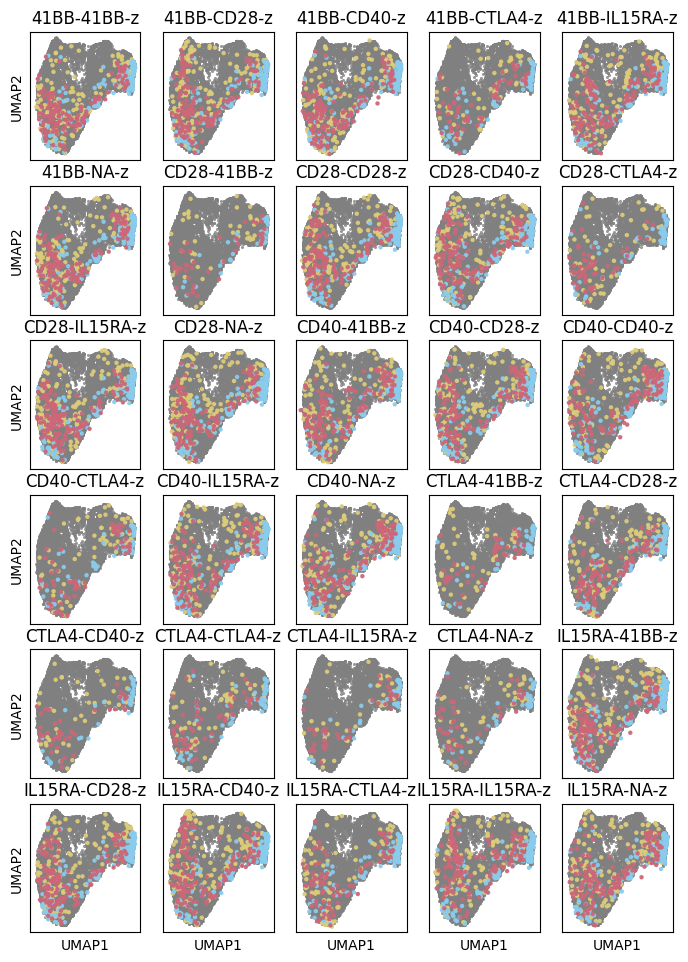

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2024-09-19 15:17:56.715 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:17:56.746 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2024-09-19 15:17:56.747 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:17:56.748 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:17:56.749 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:17:56.799 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint

Evaluating on validation set


2024-09-19 15:18:03.405 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:03.423 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2024-09-19 15:18:03.424 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:03.424 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:03.425 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:03.578 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:06.171 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:06.192 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2024-09-19 15:18:06.192 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:06.193 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:06.194 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:06.227 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:08.727 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:08.745 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2024-09-19 15:18:08.746 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:08.747 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:08.748 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:08.778 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:11.083 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:11.102 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2024-09-19 15:18:11.102 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:11.103 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:11.103 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:11.263 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:13.834 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:13.853 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2024-09-19 15:18:13.854 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:13.855 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:13.856 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:13.886 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:16.798 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:16.816 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2024-09-19 15:18:16.817 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:16.817 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:16.818 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:16.848 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:19.113 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:19.133 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2024-09-19 15:18:19.133 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:19.134 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:19.134 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:19.168 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:21.728 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:21.748 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2024-09-19 15:18:21.748 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:21.749 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:21.750 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:21.783 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:24.919 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:24.939 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2024-09-19 15:18:24.939 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:24.940 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:24.941 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:24.973 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:27.341 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:27.359 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2024-09-19 15:18:27.360 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:27.361 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:27.361 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:27.393 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:30.362 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:30.384 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2024-09-19 15:18:30.384 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:30.385 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:30.504 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:30.537 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:33.135 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:33.161 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2024-09-19 15:18:33.162 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:33.162 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:33.164 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:33.201 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:35.650 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:35.668 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2024-09-19 15:18:35.669 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:35.669 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:35.670 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:35.700 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:38.541 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:38.684 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2024-09-19 15:18:38.685 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:38.685 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:38.686 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:38.727 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:41.383 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:41.400 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2024-09-19 15:18:41.401 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:41.402 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:41.403 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:41.434 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:44.353 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:44.372 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2024-09-19 15:18:44.373 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:44.373 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:44.374 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:44.404 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:46.864 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:46.886 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2024-09-19 15:18:46.887 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:46.888 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:46.889 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:47.050 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:49.701 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:49.720 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2024-09-19 15:18:49.721 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:49.721 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:49.722 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:49.752 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:51.999 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:52.019 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2024-09-19 15:18:52.019 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:52.020 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:52.021 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:52.054 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:54.316 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:54.335 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2024-09-19 15:18:54.335 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:54.336 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:54.336 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:54.485 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:57.030 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:57.048 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2024-09-19 15:18:57.049 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:57.050 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:57.051 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:57.082 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:18:59.661 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:18:59.680 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2024-09-19 15:18:59.681 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:18:59.681 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:18:59.682 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:18:59.714 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:19:01.990 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:19:02.010 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2024-09-19 15:19:02.010 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:19:02.011 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:19:02.012 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:19:02.168 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:19:04.294 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:19:04.315 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2024-09-19 15:19:04.316 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:19:04.316 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:19:04.317 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:19:04.348 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:19:08.552 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:19:08.578 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2024-09-19 15:19:08.579 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:19:08.579 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:19:08.580 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:19:08.611 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:19:11.122 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:19:11.139 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2024-09-19 15:19:11.140 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:19:11.140 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:19:11.141 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:19:11.169 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:19:14.535 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:19:14.557 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2024-09-19 15:19:14.557 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:19:14.558 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:19:14.559 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:19:14.589 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:19:17.068 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:19:17.088 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2024-09-19 15:19:17.089 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:19:17.090 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:19:17.090 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:19:17.123 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


2024-09-19 15:19:19.544 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-19 15:19:19.564 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2024-09-19 15:19:19.564 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-19 15:19:19.565 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-19 15:19:19.566 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-19 15:19:19.595 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:245 - Loaded MongeMapTrainer from checkpoint


Evaluating on validation set


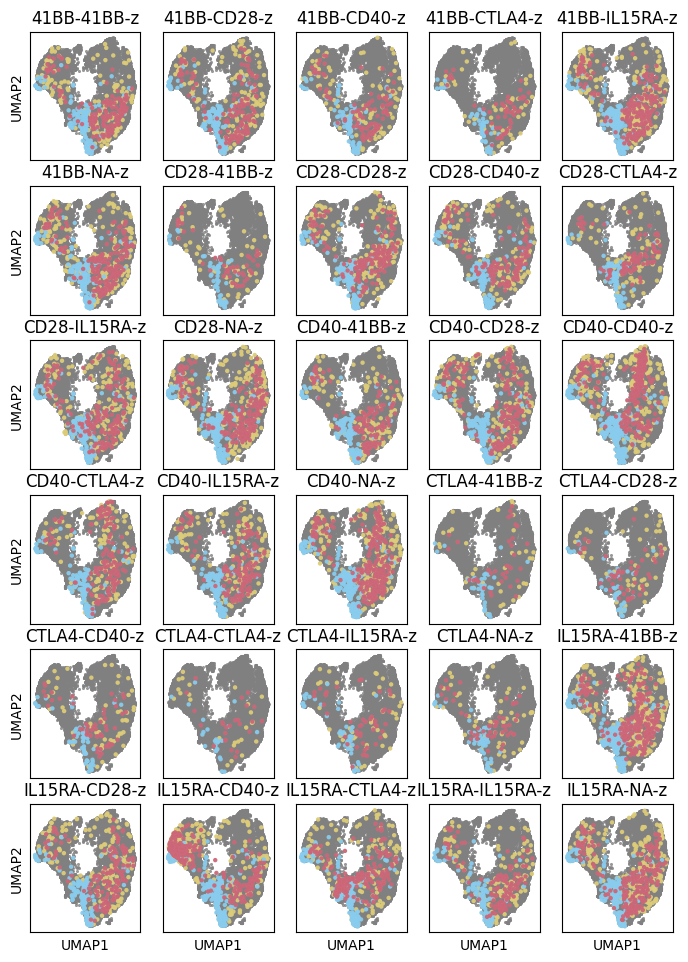

In [5]:
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f'/path/to/data/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)

    fig, axes = plt.subplots(nrows=6,ncols=5, sharex=True, sharey=True, figsize=(8.3, 11.7))
    flat_axes = axes.flatten()
    i =0
    for  car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        config_path = f"{base_config_path}FuncScore/{subset}/NA-NA-NA_{car}_config.yaml"
        config = load_config(config_path)
        config.model.checkpointing_path = f"{base_ckpt_path}NoEmbed_FuncScore_Monge_{subset}NA-NA-NA_{car}/"
        config.data.file_path = f"/path/to/adata/{subset}.h5ad"
        config.data.features = features
        config.data.drugs_path = "/path/to/variants/CAR_variants.txt"

        datamodule = CarModule(config.data)
        trainer = MongeMapTrainer.load_checkpoint(
                jobid=1, config=config.model, logger_path=logger_path
            )

        size = min(len(datamodule.control_valid_cells), len(datamodule.target_valid_cells))
        all_expr, all_meta = monge_get_source_target_transport(datamodule=datamodule, trainer=trainer, batch_size=size)

        Y2 = umapper.transform(all_expr)

        all_meta[["UMAP1", "UMAP2"]] = Y2

        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color="grey", s=5, ax=flat_axes[i], alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=10, palette=ot_map, ax=flat_axes[i], alpha=0.95, linewidth=0.01)
        flat_axes[i].get_legend().remove()
        flat_axes[i].set_title(car)
        flat_axes[i].tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        i+=1
    plt.savefig(f"{base_fig_save}{subset}_all.pdf", bbox_inches="tight", dpi=300)
    plt.show()

In [6]:
all_meta

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,CAR_Variant,Donor,Time,Lane,Sample,...,Proinflamatory_2,Memory_3,CD4_Th1_4,CD4_Th2_5,ident,time_subset,sample_n,dtype,UMAP1,UMAP2
0,S_D09_T12,2998.0,1541,1451.0,20,IL15RA-NA-z,D09,T12,S,T12_D09,...,-0.661921,-0.244055,-0.388878,-0.199620,Terminal,late,0,target,2.342667,5.101659
1,A_D17_T0,12904.0,3312,1434.0,20,IL15RA-NA-z,D17,T0,A,T0_D17,...,-0.010548,0.482761,-0.222016,-0.255045,CD8_Activated,early,0,target,11.027287,1.125898
2,G_D17_T0,17480.0,4424,3012.0,20,IL15RA-NA-z,D17,T0,G,T0_D17,...,0.510417,-0.028201,0.048295,-0.066683,CD8_Activated,early,0,target,9.618652,5.054798
3,P_D09_T0,9773.0,2955,3528.0,20,IL15RA-NA-z,D09,T0,P,T0_D09,...,0.306142,-0.020602,-0.097141,-0.229178,CD8_Activated,early,0,target,8.671215,4.716663
4,L_D17_T6,8664.0,3099,731.0,20,IL15RA-NA-z,D17,T6,L,T6_D17,...,-0.458391,-0.287196,-0.590971,-0.239627,CD8_Late_Cytotoxic,late,0,target,3.205114,7.179207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,Q_D09_T0,7150.0,2322,1411.0,20,IL15RA-NA-z,D09,T0,Q,T0_D09,...,0.215193,-0.188254,-0.266104,-0.193321,CD8_Activated,early,0,transport,8.480757,0.459892
692,A_D17_T0,25083.0,4751,2548.0,20,IL15RA-NA-z,D17,T0,A,T0_D17,...,-0.270830,0.538869,-0.586526,-0.219887,CD8_Activated,early,0,transport,7.720863,2.139814
693,A_D17_T0,12794.0,3503,2221.0,21,IL15RA-NA-z,D17,T0,A,T0_D17,...,1.127118,0.075113,1.393923,0.081130,CD8_Activated,early,0,transport,9.511378,0.903857
694,P_D09_T0,9504.0,3245,2295.0,20,IL15RA-NA-z,D09,T0,P,T0_D09,...,-0.807747,0.020691,-0.354392,-0.297619,CD8_Activated,early,0,transport,9.183071,0.523308
